In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/greydanus/mnist1d
import mnist1d
from mnist1d.data import get_templates, get_dataset_args, get_dataset
from mnist1d.utils import set_seed, plot_signals, ObjectView, from_pickle

fatal: destination path 'mnist1d' already exists and is not an empty directory.


In [3]:
data = get_dataset(get_dataset_args()) # Default = mnist1d_data.pkl

# Set the batch size for training & testing
X_train, y_train = data['x'], data['y']
X_test, y_test = data['x_test'], data['y_test']

n_features, n_classes = X_train.shape[1], 10

File already exists. Skipping download.
Successfully loaded data from ./mnist1d_data.pkl


In [4]:
def gen_mini_batch(batch_size):
    idxs = np.random.randint(0, high=X_train.shape[0], size=batch_size)
    return X_train[idxs], y_train[idxs]

def one_hot(xs, n_classes=10):
    ys = np.zeros((xs.shape[0], n_classes))
    for i, x in enumerate(xs):
        ys[i, x] = 1

    return ys

In [5]:
import alsograd as ag
import alsograd.nn as nn
import alsograd.nn.functions as F
from alsograd.nn.optimizer import *

In [6]:
def get_acc(y_pred, y):
    return (np.argmax(y_pred, axis=1) == y).mean()

# Train
def train(optimizer, model, batch_size=128, n_epoch=5, n_batches=200):
    losses, accuracies = [], []

    for _ in range(n_epoch):
        for _ in range(n_batches):
            images, labels = gen_mini_batch(batch_size)
            images, labels_oh = ag.Parameter(images, requires_grad=False), one_hot(labels)

            optimizer.zero_grad()

            y = model(images)
            acc = get_acc(y.data, labels)

            # Cross-entropy
            loss = (-F.softmax(y).log()*labels_oh).mean()*n_classes
            loss.backward()

            optimizer.step()

            # Process
            losses.append(loss)
            accuracies.append(acc)
            print('Loss: {:.3f}, acc: {:.3f}'.format(loss.data[0], acc), end="\r")

    return losses, accuracies
            
def plot_train_results(losses, accuracies):
    losses_np = [l.data[0] for l in losses]

    plt.plot(losses_np, label='Loss')
    plt.plot(accuracies, label='Accuracy')
    plt.ylim([0, 5])
    plt.legend()
    plt.grid()

In [7]:
class Net(nn.Module):
    def __init__(self, hidden_size=10):
        super().__init__()

        self.seq = nn.GRU(1, hidden_size)
        self.l1 = nn.Linear(n_features*hidden_size, n_classes)

    def forward(self, x):
        x = x.reshape(*x.shape, 1) # Reshape to batch_size, time_steps, dims
        x = self.seq(x).ravel(1)
        return self.l1(x)

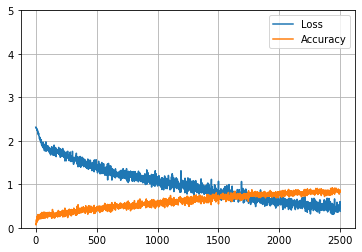

In [8]:
model = Net()
optimizer = SGD(model, learning_rate=1e-1, momentum=0.9)

losses, accuracies = train(optimizer, model, batch_size=128, n_batches=500)
plot_train_results(losses, accuracies)